# Spherical annulus

Poisson solver in the spherical annulus (wikipedia). $\theta$ is polar angle
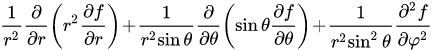

$\partial/\partial \theta = 0$, \theta = pi/2:
$
\frac{1}{r^2}\frac{\partial}{\partial r}\left( r^2 \frac{\partial f}{\partial r}\right)
+ \frac{1}{r^2}\frac{\partial^2 f}{\partial \psi^2}
$

In [27]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [58]:
struct EquatorialGrid
    r::Vector
    psi::Vector
    rc::Vector
    psic::Vector
    nr::Int
    npsi::Int
    dr::Float64
    dpsi::Float64
    full_circle::Bool
    function EquatorialGrid(psi_max,npsi,r_min,r_max,nr; periodic=false)
        if psi_max ≈ 2.0*pi || periodic
            full_circle = true
        else
            full_circle = false
        end
        psi_min = 0.0
        dpsi = (psi_max-psi_min)/(npsi-1)
        dr   = (r_max-r_min)/(nr-1)
        psi  = LinRange(psi_min,psi_max,npsi)
        r    = LinRange(r_min,r_max,nr)
        rc   = LinRange(r_min-dr/2.,r_max+dr/2.,nr+1)
        psic = LinRange(psi_min-dpsi/2.,psi_max+dpsi/2.,npsi+1)
        new(r,psi,rc,psic,nr,npsi,dr,dpsi,full_circle)
    end
end

function form_poisson_sphan(grid::EquatorialGrid)
   @inline dof(i::Int,j::Int) = (j-1)*grid.nr + i # Gerya 3.22

    # pre-allocate arrays to store indices and values
    nn = grid.nr * grid.npsi
    row = zeros(Int64,5*nn) # up to 5 nonzeros per row
    col = zeros(Int64,5*nn)
    value = zeros(Float64, 5*nn)
    R = zeros(Float64,nn,1)
    k=1
    jmax = grid.full_circle ? grid.npsi-1 : grid.npsi
    for j in 1:jmax
        for i in 1:grid.nr
            this_row = dof(i,j)
            if i==1 || i == grid.nr || j == 1 || j == jmax
                row[k] = this_row; col[k] = this_row; value[k] = 1.0; k+=1
                R[this_row] = 0.0;
            else
            rp = grid.rc[i+1]
            rm = grid.rc[i]
            r = grid.r[i]
            drp = i < grid.nr ? grid.r[i+1]-grid.r[i] : grid.r[i]-grid.r[i-1]
            drm = i > 1 ? grid.r[i]-grid.r[i-1] : grid.r[i+1]-grid.r[i]
            drc = 0.5*(drp+drm)
            dpsip = j < jmax ? grid.psi[j+1]-grid.psi[j]   : grid.psi[j]-grid.psi[j-1]
            dpsim = j > 1    ? grid.psi[j] - grid.psi[j-1] : grid.psi[j+1]-grid.psi[j]
            dpsic = 0.5*(dpsip+dpsim)


            # diagonal value
            row[k] = this_row; col[k] = this_row; value[k] = -1.0/r^2/dpsim/dpsic - 1.0/r^2/dpsip/dpsic-rp^2/r^2/drp/drc - rm^2/r^2/drm/drc; k+=1;
            # i-1,j (down)
            row[k] = this_row; col[k] = dof(i-1,j); value[k] = r^2/rp^2/drm/drc; k+=1;
            # i+1,j (up)
            row[k] = this_row; col[k] = dof(i+1,j); value[k] = r^2/rp^2/drp/drc; k+=1;
            # i,j-1 (left)
            row[k] = this_row; col[k] = dof(i,j-1); value[k] = 1.0/r^2/dpsim/dpsic; k+=1;
            # i,j+1 (right)
            row[k] = this_row; col[k] = dof(i,j+1); value[k] = 1.0/r^2/dpsip/dpsic; k+=1;
            R[this_row] = 1.0;
        end
        end
    end
    if grid.full_circle
        j = grid.npsi
        for i in 1:grid.nr
            this_row = dof(i,j)
            row[k] = this_row; col[k] = this_row; value[k] =  1.0; k+=1;
            row[k] = this_row; col[k] = dof(i,1); value[k] = -1.0; k+=1;
        end
    end
    @views row = row[1:(k-1)]
    @views col = col[1:(k-1)]
    @views value = value[1:(k-1)]
    L = sparse(row,col,value)
    return L,R
end

form_poisson_sphan (generic function with 1 method)

In [63]:
# Create the equatorial grid
grid = EquatorialGrid(2*pi,361,3541.,6371.,65);
L,R = form_poisson_sphan(grid);
sol = L\R;
sol = reshape(sol,grid.nr,grid.npsi);

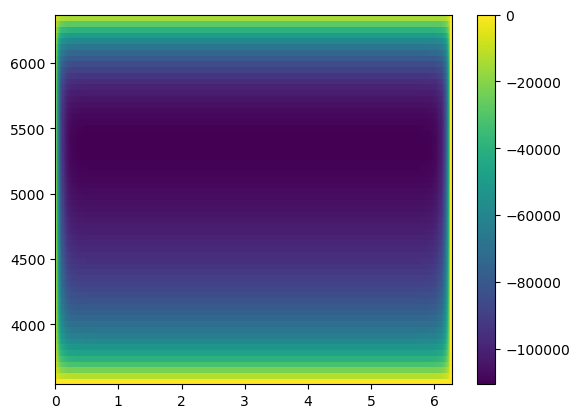

In [65]:
figure()
pcolor(grid.psi,grid.r,sol)
colorbar()
show()